# Hybrid Quantum-Classical Decoder Transformer

In [953]:
import math
import tiktoken
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import pennylane as qml

## Data Processing and Tokenization

In [ ]:
# Tokenizer & Data Processing for Language Modeling 

tokenizer = tiktoken.get_encoding("gpt2")
vocab_size = tokenizer.n_vocab


def tokenize(text: str) -> torch.Tensor:
    """Convert a string into a 1D tensor of token IDs."""
    ids = tokenizer.encode(text)
    return torch.tensor(ids, dtype=torch.long)


def detokenize(id_tensor: torch.Tensor) -> str:
    """Convert token IDs back into a string."""
    return tokenizer.decode(id_tensor.tolist())


# Load corpus text for training 
with open("corpus.txt", "r", encoding="utf-8") as f:
    corpus_text = f.read()

token_ids = tokenize(corpus_text)  # 1D tensor of token IDs
print(f"Number of tokens in corpus: {len(token_ids):,}")


# Dataset for next-token prediction 

class NextTokenDataset(Dataset):
    """
    Produces (input, target) pairs for next-token prediction:
      input  x = token_ids[i : i+T]
      target y = token_ids[i+1 : i+T+1]
    So the model learns to predict the next token at each position.
    """
    def __init__(self, token_ids: torch.Tensor, context_length: int):
        self.token_ids = token_ids
        self.context_length = context_length

    def __len__(self):
        return len(self.token_ids) - self.context_length - 1

    def __getitem__(self, index):
        # chunk has length T+1
        chunk = self.token_ids[index : index + self.context_length + 1]
        x = chunk[:-1].clone().detach().long()  # (T,)
        y = chunk[1:].clone().detach().long()   # (T,)
        return x, y


# --- Build train/validation datasets and loaders ---

CONTEXT_LENGTH = 20  # number of tokens model looks at per example
split_index = int(0.9 * len(token_ids)) #90/10 train-val split

train_dataset = NextTokenDataset(token_ids[:split_index], CONTEXT_LENGTH)
val_dataset   = NextTokenDataset(token_ids[split_index:],  CONTEXT_LENGTH)

BATCH_SIZE = 32  # how many sequences you feed into the model at once

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# Quick check
sample_x, sample_y = train_dataset[0]
print("Decoded sample input:\n", detokenize(sample_x))


Number of tokens in corpus: 1,388
Decoded sample input:
 Many athletes are considered the greatest in their respective sports: Tiger Woods, Michael Jordan, Lebron


## Transformer Setup

In [881]:
# Attention Mechanism
class CausalSelfAttention(nn.Module):
    """
    Single-head causal self-attention with optional dropout.
    Input:  X of shape (B, T, d_model)
    Output: Z of shape (B, T, d_out) and optionally attention weights (B, T, T)
    """
    def __init__(self, d_model, d_k=None, d_v=None, d_out=None,
                 dropout=0.0, use_bias=False, causal=True):
        super().__init__()
        d_k = d_model if d_k is None else d_k
        d_v = d_model if d_v is None else d_v
        d_out = d_v if d_out is None else d_out

        self.d_model = d_model
        self.d_k = d_k
        self.causal = causal

        self.W_Q = nn.Linear(d_model, d_k, bias=use_bias)
        self.W_K = nn.Linear(d_model, d_k, bias=use_bias)
        self.W_V = nn.Linear(d_model, d_v, bias=use_bias)
        self.W_O = nn.Linear(d_v, d_out, bias=True)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, return_attn=False):
        """
        x: (B, T, d_model)
        """
        B, T, _ = x.shape

        Q = self.W_Q(x)  # (B, T, d_k)
        K = self.W_K(x)  # (B, T, d_k)
        V = self.W_V(x)  # (B, T, d_v)

        # Scaled dot-product attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)  # (B, T, T)

        # Causal mask: no attending to future positions
        if self.causal:
            mask = torch.triu(
                torch.ones(T, T, device=x.device, dtype=torch.bool),
                diagonal=1
            )  # True above diagonal
            scores = scores.masked_fill(mask, float("-inf"))

        A = F.softmax(scores, dim=-1)  # (B, T, T)
        A = self.dropout(A)

        context = torch.matmul(A, V)   # (B, T, d_v)
        z = self.W_O(context)          # (B, T, d_out)

        if return_attn:
            return z, A
        return z, None


class MultiHeadAttention(nn.Module):
    """
    Multi-head causal self-attention built from CausalSelfAttention.
    """
    def __init__(self, d_in, d_out, num_heads,
                 dropout=0.0, use_bias=False, causal=True):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.head_dim = d_out // num_heads
        self.num_heads = num_heads

        # Each head is a single-head causal self-attention module
        self.heads = nn.ModuleList([
            CausalSelfAttention(
                d_model=d_in,
                d_k=self.head_dim,
                d_v=self.head_dim,
                d_out=self.head_dim,
                dropout=dropout,
                use_bias=use_bias,
                causal=causal,
            )
            for _ in range(num_heads)
        ])

        # Final linear projection after concatenation
        self.proj_out = nn.Linear(num_heads * self.head_dim, d_out)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, return_all_attn=False):
        """
        x: (B, T, d_in)
        returns:
          y: (B, T, d_out)
          attn_weights: (B, H, T, T) if return_all_attn=True, else None
        """
        outs = []
        attn_list = []

        for head in self.heads:
            z_h, A_h = head(x, return_attn=return_all_attn)  # (B, T, head_dim), (B, T, T)
            outs.append(z_h)
            if return_all_attn:
                attn_list.append(A_h)

        # Concatenate head outputs
        Z_concat = torch.cat(outs, dim=-1)            # (B, T, H * head_dim)
        y = self.dropout(self.proj_out(Z_concat))     # (B, T, d_out)

        if return_all_attn:
            A_stack = torch.stack(attn_list, dim=1)   # (B, H, T, T)
            return y, A_stack
        return y, None


In [ ]:
# Feed-Forward Layers (Classical and Quantum) 

class PositionwiseFeedForward(nn.Module):
    """
    Classical position-wise feed-forward network:
      Input:  (B, T, d_model)
      Output: (B, T, d_model)
    """
    def __init__(self, d_model, d_ff, dropout=0.0):
        super().__init__()
        print("Initialized Classical FNN")
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


# QNN-based feed-forward using a manual QNode 

class QNNFeedForward(nn.Module):
    """
    Quantum position-wise feed-forward layer:
      Input:  (B, T, d_model)
      Output: (B, T, d_model)

    Per-token pipeline:
      x (d_model) -> Linear(d_model -> M)
                    -> QNN(M -> M) via PennyLane QNode
                    -> Linear(M -> d_model)
    """
    def __init__(self, d_model: int, num_qubits: int = 4, num_layers: int = 2, dropout: float = 0.0):
        super().__init__()
        print("Initialized QNN")
        self.d_model = d_model
        self.num_qubits = num_qubits
        self.num_layers = num_layers

        # Classical projections
        self.project_in  = nn.Linear(d_model, num_qubits)
        self.project_out = nn.Linear(num_qubits, d_model)

        # Variational parameters:
        self.theta = nn.Parameter(
            0.01 * torch.randn(num_layers, num_qubits, 3)
        )

        # PennyLane device for this layer
        self.dev = qml.device("lightning.qubit", wires=num_qubits)

        # Define the circuit and wrap it as a QNode with torch interface
        def circuit(inputs, theta):
            """
            inputs: shape (M,) torch tensor
            theta:  shape (L, M, 3) torch tensor
            """
            # 1) Angle encoding (your encode(x))
            for j in range(num_qubits):
                qml.RY(inputs[j], wires=j)

            # 2) Variational ansatz (your variational(theta, L))
            for l in range(num_layers):
                for j in range(num_qubits):
                    qml.RY(theta[l, j, 0], wires=j)
                    qml.RZ(theta[l, j, 1], wires=j)
                    qml.RY(theta[l, j, 2], wires=j)
                # ring entanglement
                for j in range(num_qubits):
                    qml.CNOT(wires=[j, (j + 1) % num_qubits])

            # 3) Measure Z on each qubit -> M-dimensional output
            return [qml.expval(qml.PauliZ(j)) for j in range(num_qubits)]

        # QNode object with torch interface
        self.qnode = qml.QNode(circuit, self.dev, interface="torch")

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
            """
            x: (B, T, d_model)
            """
            B, T, D = x.shape
            assert D == self.d_model

            # Flatten tokens: (B, T, D) -> (B*T, D)
            x_flat = x.reshape(B * T, D)

            # Project into M-dimensional qubit feature space
            features = self.project_in(x_flat)  # (B*T, M)

            # Call QNode once per token
            qnn_outputs = []
            for feat in features:
                # feat: shape (M,)
                q_out = self.qnode(feat, self.theta)  # list or 1D tensor of length M

                # FIX: ensure q_out is a single torch.Tensor of shape (M,)
                if isinstance(q_out, list):
                    # q_out is a list of scalar tensors -> stack into (M,)
                    q_out = torch.stack(q_out)

                qnn_outputs.append(q_out)

            # Now qnn_outputs is a list of tensors, so this works:
            qnn_outputs = torch.stack(qnn_outputs, dim=0)  # (B*T, M)

            # Project back to d_model and reshape
            y_flat = self.project_out(qnn_outputs)   # (B*T, d_model)
            y_flat = self.dropout(y_flat)

            y = y_flat.view(B, T, D)                 # (B, T, d_model)
            return y


In [883]:
# Transformer Block and Decoder-Only Transformer Model

class TransformerBlock(nn.Module):
    """
    Single decoder-style Transformer block:
      - LayerNorm
      - Multi-head causal self-attention + residual
      - LayerNorm
      - Feed-forward (classical or QNN) + residual
    """
    def __init__(self,
                 d_model: int,
                 num_heads: int,
                 d_ff: int,
                 dropout: float = 0.0,
                 use_bias: bool = False,
                 causal: bool = True,
                 use_qnn_ff: bool = False,
                 qnn_num_qubits: int = 4,
                 qnn_num_layers: int = 2):
        super().__init__()

        self.norm1 = nn.LayerNorm(d_model)
        self.attn  = MultiHeadAttention(
            d_in=d_model,
            d_out=d_model,
            num_heads=num_heads,
            dropout=dropout,
            use_bias=use_bias,
            causal=causal,
        )

        self.norm2 = nn.LayerNorm(d_model)

        self.use_qnn_ff = use_qnn_ff
        if use_qnn_ff:
            self.ff = QNNFeedForward(
                d_model=d_model,
                num_qubits=qnn_num_qubits,
                num_layers=qnn_num_layers,
                dropout=dropout,
            )
        else:
            self.ff = PositionwiseFeedForward(
                d_model=d_model,
                d_ff=d_ff,
                dropout=dropout,
            )

    def forward(self, x, return_attn=False):
        """
        x: (B, T, d_model)
        """
        # Self-attention sub-layer
        z_attn, A = self.attn(self.norm1(x), return_all_attn=return_attn)
        x_res = x + z_attn

        # Feed-forward sub-layer
        z_ff = self.ff(self.norm2(x_res))
        x_out = x_res + z_ff

        return (x_out, A) if return_attn else (x_out, None)


class MiniDecoderTransformer(nn.Module):
    """
    Small decoder-only Transformer language model:
      - Token + positional embeddings
      - Stack of Transformer blocks (decoder-style)
      - Final LayerNorm
      - Linear projection to vocabulary size
    """
    def __init__(self,
                 vocab_size: int,
                 d_model: int,
                 num_layers: int,
                 num_heads: int,
                 d_ff: int,
                 dropout: float = 0.1,
                 max_context_length: int = 1024,
                 use_qnn_ff: bool = False,
                 qnn_num_qubits: int = 4,
                 qnn_num_layers: int = 2):
        super().__init__()

        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_context_length, d_model)

        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(
                d_model=d_model,
                num_heads=num_heads,
                d_ff=d_ff,
                dropout=dropout,
                use_bias=True,
                causal=True,
                use_qnn_ff=use_qnn_ff,
                qnn_num_qubits=qnn_num_qubits,
                qnn_num_layers=qnn_num_layers,
            )
            for _ in range(num_layers)
        ])

        self.final_norm = nn.LayerNorm(d_model)

        # Language modeling head (tied weights with token embedding)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.token_embedding.weight

    def forward(self, token_indices, return_attn=False):
        """
        token_indices: (B, T) integer token IDs.
        """
        B, T = token_indices.shape
        device = token_indices.device

        positions = torch.arange(T, device=device)

        x = self.token_embedding(token_indices) + self.position_embedding(positions)
        x = self.dropout(x)

        attn_maps = []
        for block in self.blocks:
            x, A = block(x, return_attn=return_attn)
            if return_attn:
                attn_maps.append(A)

        x = self.final_norm(x)
        logits = self.lm_head(x)  # (B, T, vocab_size)

        if return_attn:
            # attn_maps: list of (B, H, T, T) or None
            if attn_maps and attn_maps[0] is not None:
                attn_stack = torch.stack(attn_maps, dim=0)  # (L, B, H, T, T)
            else:
                attn_stack = None
            return logits, attn_stack

        return logits


In [ ]:
# Loss, Training Loop, and Text Generation 

def language_model_loss(model, x, y):
    """
    Cross-entropy loss for next-token prediction.
    x: (B, T) token IDs (input)
    y: (B, T) token IDs (target)
    """
    logits = model(x)  # (B, T, vocab_size)
    B, T, V = logits.shape
    return F.cross_entropy(logits.reshape(-1, V), y.reshape(-1))

@torch.no_grad()
def evaluate_loss(model, data_loader, device):
    """
    Compute average cross-entropy loss over a whole DataLoader
    """
    model.eval()
    losses = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = language_model_loss(model, x, y)
        losses.append(loss.item())
    model.train()  # switch back to training mode
    return sum(losses) / len(losses)

def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    num_steps=200,
    log_every=50,
    device=torch.device("cpu"),
    label="model",
):
    """
    Train the model for a fixed number of optimization steps, and track:
      - training loss (logged every `log_every` steps)
      - validation loss
      - validation perplexity
    """
    model.train()
    data_iter = iter(train_loader)
    running_loss = 0.0

    history = {
        "step": [],
        "train_loss": [],
        "val_loss": [],
        "val_ppl": [],
    }

    for step in range(1, num_steps + 1):
        try:
            x, y = next(data_iter)
        except StopIteration:
            data_iter = iter(train_loader)
            x, y = next(data_iter)

        x = x.to(device)
        y = y.to(device)

        # --- forward & backward ---
        loss = language_model_loss(model, x, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()

        # --- logging / validation every log_every steps ---
        if step % log_every == 0:
            avg_train_loss = running_loss / log_every
            running_loss = 0.0

            # validation loss
            val_loss = evaluate_loss(model, val_loader, device)
            val_ppl = math.exp(val_loss)

            print(
                f"[{label}] step {step:4d} | "
                f"train_loss={avg_train_loss:.4f} | "
                f"val_loss={val_loss:.4f} | "
                f"val_ppl={val_ppl:.2f}"
            )

            # store in history
            history["step"].append(step)
            history["train_loss"].append(avg_train_loss)
            history["val_loss"].append(val_loss)
            history["val_ppl"].append(val_ppl)

    return history


@torch.no_grad()
def generate_autoregressive(model,
                            token_indices,
                            max_new_tokens=50,
                            temperature=1.0,
                            top_k=None):
    """
    Autoregressive text generation from a starting sequence.

    Args:
        model: MiniDecoderTransformer
        token_indices: (B, T_start) int token IDs
        max_new_tokens: how many tokens to generate
        temperature: >1 = more random, <1 = more greedy
        top_k: if set, retain only top_k logits before softmax

    Returns:
        (B, T_start + max_new_tokens) token IDs
    """
    model.eval()
    for _ in range(max_new_tokens):
        logits = model(token_indices)[:, -1, :]  # (B, vocab_size) at last position
        logits = logits / max(temperature, 1e-8)

        if top_k is not None:
            values, indices = torch.topk(logits, k=top_k, dim=-1)
            mask = torch.full_like(logits, float("-inf"))
            logits = mask.scatter(1, indices, values)

        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)  # (B, 1)

        token_indices = torch.cat([token_indices, next_token], dim=1)

    return token_indices


## Train Decoder Transformer

In [ ]:
# Setup Base Configuration

device = torch.device("cpu")

base_config = dict(
    vocab_size=vocab_size,
    d_model=128,             # can scale up once it works
    num_layers=4,           # number of Transformer blocks
    num_heads=4,            # number of heads for MHA
    d_ff=128,               # dimension of Classical FFN
    dropout=0.1,            # percentage of dropout nodes during training
    max_context_length=20,  # Max context window size
    qnn_num_qubits=3,       # number of qubits / QNN input dim
    qnn_num_layers=2,       # number of variational layers
)


print("device:", device)

device: cpu


In [ ]:
# Classical FFN Transformer
classical_model = MiniDecoderTransformer(
    **base_config,
    use_qnn_ff=False,
).to(device)

opt_classical = torch.optim.AdamW(
    classical_model.parameters(), lr=3e-4, weight_decay=0.01
)
# Train and get history
history_classical = train_model(
    classical_model,
    train_loader,
    val_loader,
    opt_classical,
    num_steps=400,
    log_every=20,
    device=device,
    label="classical",
)

Initialized Classical FNN
Initialized Classical FNN
Initialized Classical FNN
Initialized Classical FNN
[classical] step   20 | train_loss=67.0835 | val_loss=49.4706 | val_ppl=3053629787312655171584.00
[classical] step   40 | train_loss=40.3464 | val_loss=34.4868 | val_ppl=949337276014649.50
[classical] step   60 | train_loss=30.9741 | val_loss=28.2144 | val_ppl=1792079988998.12
[classical] step   80 | train_loss=26.3936 | val_loss=24.6889 | val_ppl=52752606112.66
[classical] step  100 | train_loss=23.2188 | val_loss=22.2723 | val_ppl=4707059925.57
[classical] step  120 | train_loss=21.0052 | val_loss=20.2688 | val_ppl=634776123.68
[classical] step  140 | train_loss=19.0986 | val_loss=18.6066 | val_ppl=120430487.52
[classical] step  160 | train_loss=17.3220 | val_loss=17.1197 | val_ppl=27225151.58
[classical] step  180 | train_loss=15.7682 | val_loss=15.7668 | val_ppl=7037494.24
[classical] step  200 | train_loss=14.2891 | val_loss=14.5556 | val_ppl=2096183.97
[classical] step  220 | t

In [ ]:
# QNN FFN Transformer
qnn_model = MiniDecoderTransformer(
    **base_config,
    use_qnn_ff=True,
).to(device)

opt_qnn = torch.optim.AdamW(
    qnn_model.parameters(), lr=3e-4, weight_decay=0.01
)
# Train and get history
history_qnn = train_model(
    qnn_model,
    train_loader,
    val_loader,
    opt_qnn,
    num_steps=400,
    log_every=20,
    device=device,
    label="qnn",
)

Initialized QNN
Initialized QNN
Initialized QNN
Initialized QNN
[qnn] step   20 | train_loss=55.0320 | val_loss=45.8921 | val_ppl=85249831899115094016.00
[qnn] step   40 | train_loss=40.1316 | val_loss=35.0851 | val_ppl=1726937910238453.25
[qnn] step   60 | train_loss=32.1671 | val_loss=29.4216 | val_ppl=5993136091988.10
[qnn] step   80 | train_loss=27.6908 | val_loss=25.8348 | val_ppl=165931375421.40
[qnn] step  100 | train_loss=24.5955 | val_loss=23.3275 | val_ppl=13520566032.99
[qnn] step  120 | train_loss=22.1161 | val_loss=21.1333 | val_ppl=1506853196.07
[qnn] step  140 | train_loss=20.1164 | val_loss=19.2454 | val_ppl=228127529.32
[qnn] step  160 | train_loss=18.4709 | val_loss=17.6726 | val_ppl=47328565.27
[qnn] step  180 | train_loss=16.8707 | val_loss=16.3246 | val_ppl=12293995.35
[qnn] step  200 | train_loss=15.5674 | val_loss=15.2705 | val_ppl=4284411.78
[qnn] step  220 | train_loss=14.2289 | val_loss=14.3776 | val_ppl=1754300.85
[qnn] step  240 | train_loss=13.3748 | val_lo

## Autoregressive Text Generation

In [940]:
print("[Classical Text Generation]")
start_text = "Many"
start_ids = tokenize(start_text).unsqueeze(0).to(device)  # (1, T_start)

generated_ids = generate_autoregressive(
    classical_model,
    start_ids,
    max_new_tokens=15,  # max tokens to generate
    temperature=1,      # controls randomness (rescales logits before softmax)
    top_k=50,           # restricts sample to top k most likely tokens
)[0]

print(detokenize(generated_ids))

[Classical Text Generation]
Many a 
 rathers throughout to worst Joan the an influential, to the


In [948]:
print("[QNN Text Generation]")
start_text = "Many"
start_ids = tokenize(start_text).unsqueeze(0).to(device)  # (1, T_start)

generated_ids = generate_autoregressive(
    qnn_model,
    start_ids,
    max_new_tokens=15,  # max tokens to generate
    temperature=1,      # controls randomness (rescales logits before softmax)
    top_k=50,           # restricts sample to top k most likely tokens
)[0]

print(detokenize(generated_ids))

[QNN Text Generation]
Many be� crimes be considered the, and philosophers, he and with his�


## Findings

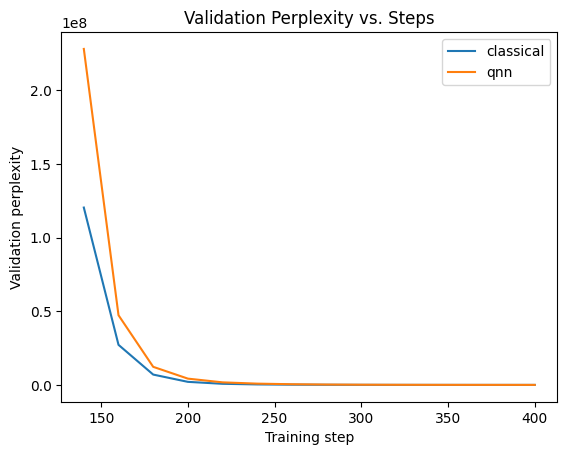

In [949]:
N = 14
# Graph Validation Perplexity vs Step Count
plt.title("Validation Perplexity vs. Steps")
#plt.yscale("log")
plt.plot(
    history_classical["step"][-N:], 
    history_classical["val_ppl"][-N:], 
    label="classical")
plt.plot(
    history_qnn["step"][-N:], 
    history_qnn["val_ppl"][-N:], 
    label="qnn")
plt.xlabel("Training step")
plt.ylabel("Validation perplexity")
plt.legend()
plt.show()

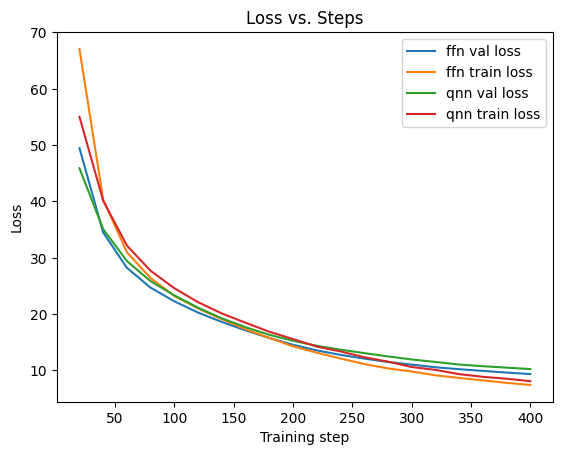

In [951]:
# Graph Training and Validation Loss vs Step Count
plt.title("Loss vs. Steps")
plt.plot(history_classical["step"], history_classical["val_loss"], label="ffn val loss")
plt.plot(history_classical["step"], history_classical["train_loss"], label="ffn train loss")
plt.plot(history_qnn["step"], history_qnn["val_loss"], label="qnn val loss")
plt.plot(history_qnn["step"], history_qnn["train_loss"], label="qnn train loss")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.legend()
plt.show()